In [50]:
# nbi:hide_in

import numpy as np
from ipywidgets import interact, interactive
import ipywidgets
from matplotlib import pyplot as plt

%matplotlib inline

In [39]:
# nbi:hide_in

def get_equation(X1, X2):
    x1, y1 = X1
    x2, y2 = X2
    if x2 == x1:
        return
    else:
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        assert np.isclose(intercept, y2 - slope * x2), 'expected {} instead {}'.format(intercept, y2 - slope * x2)
        return slope, intercept

def get_intersection(eq1, eq2):
    if eq1 is None or eq2 is None:
        return 
    a1, b1 = eq1
    a2, b2 = eq2
    if np.isclose(a1, a2):
        return
    xint = (b2 - b1 ) / (a1 - a2)
    yint = a1 * xint + b1
    assert np.isclose(yint, a2 * xint + b2), 'expected {} instead {}'.format(yint, a2 * xint + b2)
    return xint, yint

def make_equation(a, b):
    def function(x):
        return a*x+b
    return function

In [40]:
# nbi:hide_in

def where_insert(myarray, val):
    myarray = np.sort(np.asarray(myarray))
    msk = (myarray <= val)
    return msk.sum()

def where_inserts(myarray, vals):
    return np.array([where_insert(myarray, val) for val in vals])
    
def cut_according_to(tocut, cutting):
    assert (cutting[0] > tocut[0]) and (cutting[-1] < tocut[-1])
    indices = where_inserts(tocut, cutting)
    ret = [np.concatenate((tocut[:indices[0]], [cutting[0]]))]
    l = indices[0]
    for i, ind in enumerate(indices[1:]):
        tmp = np.concatenate(([cutting[i]], tocut[l:ind], [cutting[i+1]]))
        ret.append(tmp)
        l = ind
    ret.append(np.concatenate(([cutting[-1]], tocut[indices[-1]:])))
    return ret

def middle(array):
    return (max(array) + min(array)) / 2

def middiff(array):
    return (array[1] - array[0]) / 2 

In [41]:
# nbi:hide_in

colors = plt.get_cmap('tab10')(np.arange(0, 1.1, 0.1))

def plot_one_ray(ax, xx, from_eq, arrow=False, arrowsize=1, headwidth=0.5, **kwargs):
    if from_eq is None:
        return
    yy = make_equation(*from_eq)(xx)
    ax.plot(xx, yy, **kwargs)
    if arrow:
        plt.arrow(middle(xx), middle(yy), middiff(xx)*arrowsize, middiff(yy)*arrowsize, 
                  head_width=headwidth, color=ax.lines[-1].get_color(),
                  shape='full', lw=0)

def plot_obj(ax, obj, Aname='A', Bname='B', **kwargs):
    if obj is None:
        return
    x, y = obj
    ax.plot((x, x), (0, y), **kwargs)
    ax.text(x, 0, Aname, fontsize=20, c='k')
    ax.text(x, y, Bname, fontsize=20, c='k')

In [42]:
# nbi:hide_in

class Mirror():
    def __init__(self, origin=0, name='mirror1'):
        self.O = origin
        self.name = name
        
    def get_propagation(self, from_eq):
        # returns equation
        if from_eq is None:
            return 
        a_from, b_from = from_eq
        y_lens = a_from * self.O + b_from
        a_out = -a_from
        b_out = b_from + 2 * a_from * self.O
        return a_out, b_out
    
    def plot_context(self, ax, **kwargs):
        ax.axhline(0, c='k')
        ax.axvline(self.O, c='k', ls='--', **kwargs)  
        ax.text(self.O + 0.1, 0.1, 'mirror'+str(self.name))

class Lens():
    def __init__(self, focale, origin=0, name=''):
        self.O = origin
        self.name = name
        self.focale = focale
        
    def get_propagation(self, from_eq, inv=False):
        # return equation
        if from_eq is None:
            return 
        F = self.Fprime
        if inv: 
            F = self.F
        a_from, b_from = from_eq
        y_lens = a_from * self.O + b_from
        y_foyer = a_from * F + (b_from - y_lens)
        return get_equation((self.O, y_lens), (F, y_foyer))
        
    def get_image(self, obj, inv=False):
        if obj is None:
            return
        xobj, yobj = obj
        h_eq = (0, yobj)
        zero_eq = get_equation(obj, (self.O, 0))
        h_eq_out = self.get_propagation(h_eq, inv=inv)
        zero_eq_out = self.get_propagation(zero_eq, inv=inv)    
        return get_intersection(h_eq_out, zero_eq_out)
    
    def plot_context(self, ax):
        ax.axhline(0, c='k')
        ax.axvline(self.O, c='k', ls='--', lw=2)
        ax.scatter(self.F, 0, marker='X', c='k')
        ax.scatter(self.Fprime, 0, marker='X', c='k')
        ax.scatter(self.O, 0, marker='X', c='k')
        ax.text(self.O, -0., 'O'+str(self.name), fontsize=20)
        ax.text(self.F, -0., 'F'+str(self.name), fontsize=20)
        ax.text(self.Fprime, -0., "F\'"+str(self.name), fontsize=20)
        
    def get_parallel_ray(self, obj):
        para_eq = (0, obj[-1])
        return para_eq

    def get_center_ray(self, obj):
        center_eq = get_equation(obj, (self.O, 0))
        return center_eq    
    
    def get_focal_ray(self, obj):
        focal_eq = get_equation(obj, (self.F, 0))
        return focal_eq  
    
class ConvLens(Lens):
    def __init__(self, focale, origin=0, name='lens1'):
        super().__init__(focale, origin, name)
        self.Fprime = origin + focale
        self.F = origin - focale

class DivLens(Lens):
    def __init__(self, focale, origin=0, name='lens1'):
        super().__init__(focale, origin, name)
        self.Fprime = origin - focale
        self.F = origin + focale
        
def classify_img(img, origin):
    if img is None:
        return 'infinity'
    elif img[0] < origin:
            return 'virtual'
    else:
        return 'real'

In [43]:
# nbi:hide_in

class OpticalBench():
    def __init__(self, *lenses, mirror=False):
        # mirror is false or the position of the mirror
        self.lenses = []
        self.add_lenses(*lenses)
        self.mirror = None
        if mirror:
            self.mirror = Mirror(mirror, '')
    
    def __add__(self, lens):
        self.lenses.append(lens)
        return self
    
    def add_lenses(self, *lenses):
        for lens in lenses:
            self += lens
        
    def get_lens_attr(self, attr):
        ret = []
        for lens in self.lenses:
            ret.append(lens.__dict__[attr])
        return ret
    
    def make_propagate(self, equation, inv=False):
        ret = []
        eq = equation[:]
        lenses = self.lenses
        if inv:
            lenses = lenses[::-1]
        for lens in lenses:
            eq = lens.get_propagation(eq, inv=inv)
            ret.append(eq)
        return ret
    
    def get_image(self, obj, mirror=False):
        lens1 = self.lenses[0]
        paraeq = lens1.get_parallel_ray(obj)
        centereq = lens1.get_center_ray(obj)
        paraprop = self.make_propagate(paraeq)[-1]
        centerprop = self.make_propagate(centereq)[-1]
        img = get_intersection(paraprop, centerprop)
        if mirror is False:
            return img
        
        m_paraprop = self.mirror.get_propagation(paraprop) 
        m_centerprop = self.mirror.get_propagation(centerprop) 
        paraprop = self.make_propagate(m_paraprop, inv=True)[-1]
        centerprop = self.make_propagate(m_centerprop, inv=True)[-1]    
        img = get_intersection(paraprop, centerprop)
        return img
    
    def plot_context(self, ax):
        for lens in self.lenses:
            lens.plot_context(ax)
        if self.mirror:
            self.mirror.plot_context(ax, lw=3)
            
    def plot_propagate(self, xx, equation, ax, 
                       inv=False, arrow=False, arrowsize=1, headwidth=0.5, **kwargs):
        origins = self.get_lens_attr('O')
        equs = np.concatenate(([equation], self.make_propagate(equation, inv)))
        arrays = cut_according_to(xx, origins)
        if inv:
            arrays = arrays[::-1]
        for x, eq in zip(arrays, equs):
            if inv:
                x = x[::-1]
            plot_one_ray(ax, x, eq, arrow=arrow, arrowsize=arrowsize, headwidth=headwidth, **kwargs)

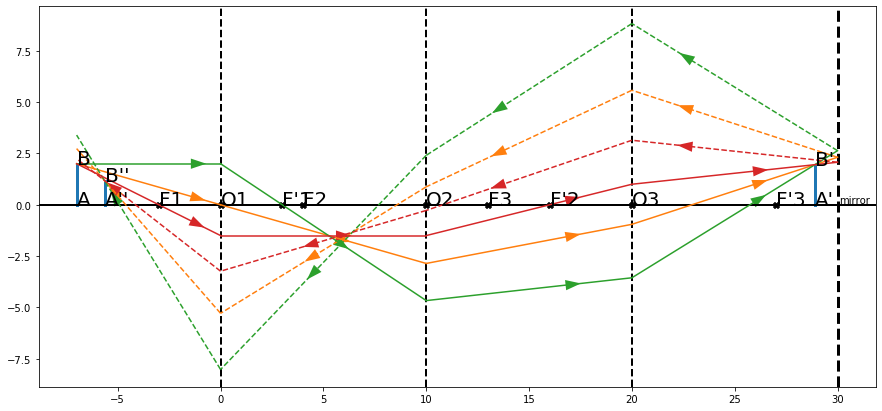

In [44]:
# nbi:hide_in

# f1, f2, f3 = 3, 6, 7
# L12, L23, L3m = 10, 10, 10

# O1 = 0
# O2 = O1 + L12
# O3 = O2 + L23
# Om = O3 + L3m

# ob = OpticalBench(ConvLens(f1, O1, '1'), ConvLens(f2, O2, '2'), ConvLens(f3, O3, '3'), mirror=Om)

# obj = [-7, 2]

# xx = np.linspace(obj[0], Om, 10)

# center = ob.lenses[0].get_center_ray(obj)
# output_ = ob.make_propagate(center)[-1]
# mirrored = ob.mirror.get_propagation(output_)

# para = ob.lenses[0].get_parallel_ray(obj)
# output_ = ob.make_propagate(para)[-1]
# mirrored_para = ob.mirror.get_propagation(output_)

# foc = ob.lenses[0].get_focal_ray(obj)
# output_ = ob.make_propagate(foc)[-1]
# mirrored_foc = ob.mirror.get_propagation(output_)

# img = ob.get_image(obj)
# img_r = ob.get_image(obj, mirror=True)

# fig, ax = plt.subplots(figsize=(15, 7))

# plot_obj(ax, obj, lw=3, c=colors[0])
# plot_obj(ax, img, lw=3, c=colors[0], Aname="A\'", Bname="B\'")
# plot_obj(ax, img_r, lw=3, c=colors[0], Aname="A\'\'", Bname="B\'\'")

# ob.plot_context(ax)
# ob.plot_propagate(xx, center, ax, c=colors[1], arrow=True, headwidth=0.5)
# ob.plot_propagate(xx, mirrored, ax, c=colors[1], inv=True, ls='--', arrow=True, headwidth=0.5)

# ob.plot_propagate(xx, para, ax, c=colors[2], arrow=True, headwidth=0.5)
# ob.plot_propagate(xx, mirrored_para, ax, c=colors[2], inv=True, ls='--', arrow=True, headwidth=0.5)

# ob.plot_propagate(xx, foc, ax, c=colors[3], arrow=True, headwidth=0.5)
# ob.plot_propagate(xx, mirrored_foc, ax, c=colors[3], inv=True, ls='--', arrow=True, headwidth=0.5)
# plt.show()

In [97]:
# nbi:hide_in

focales = [2, 4, 6, 8]

def f(yobj, L1, L12, L23, L3m, f1, f2, f3, l1, l2, l3, m, centre, parallel, focal):
    
    O1 = L1
    O2 = O1 + L12
    O3 = O2 + L23
    Om = O3 + L3m
    lens_choices = [l1, l2, l3]
    all_lenses = ConvLens(f1, O1, '1'), ConvLens(f2, O2, '2'), ConvLens(f3, O3, '3')
    lenses = [lens for i, lens in enumerate(all_lenses) if lens_choices[i]]
    mirror = [Om if m else False][0]
    obj = [0, yobj]
    
    ob = OpticalBench(*lenses, mirror=mirror)
        
    img = ob.get_image(obj)
    if m:
        img_r = ob.get_image(obj, mirror=True)

    if img:
        xx = np.linspace(min(obj[0], -f1), max(Om, img[0]), 10)
    else:
        xx = np.linspace(min(obj[0], -f1), Om, 10)
        
    fig, ax = plt.subplots(figsize=(15, 7))
    ob.plot_context(ax)
    
    plot_obj(ax, obj, lw=3, c=colors[0])
    plot_obj(ax, img, lw=3, c=colors[0], Aname="A\'", Bname="B\'")
    if m:
        plot_obj(ax, img_r, lw=3, c=colors[0], Aname="A\'\'", Bname="B\'\'")
        
    if centre:
        center = ob.lenses[0].get_center_ray(obj)
        ob.plot_propagate(xx, center, ax, c=colors[1], arrow=True, headwidth=0.5)
        if m:
            output_ = ob.make_propagate(center)[-1]
            mirrored = ob.mirror.get_propagation(output_)
            ob.plot_propagate(xx, mirrored, ax, c=colors[1], inv=True, ls='--', arrow=True, headwidth=0.5)
    if parallel:
        para = ob.lenses[0].get_parallel_ray(obj)
        ob.plot_propagate(xx, para, ax, c=colors[2], arrow=True, headwidth=0.5)
        if m:
            output_ = ob.make_propagate(para)[-1]
            mirrored_para = ob.mirror.get_propagation(output_)
            ob.plot_propagate(xx, mirrored_para, ax, c=colors[2], inv=True, ls='--', arrow=True, headwidth=0.5)

    if focal:
        foc = ob.lenses[0].get_focal_ray(obj)
        ob.plot_propagate(xx, foc, ax, c=colors[3], arrow=True, headwidth=0.5)
        if m:
            output_ = ob.make_propagate(foc)[-1]
            mirrored_foc = ob.mirror.get_propagation(output_)
            ob.plot_propagate(xx, mirrored_foc, ax, c=colors[3], inv=True, ls='--', arrow=True, headwidth=0.5)

    plt.show()

In [102]:
# nbi:hide_in

widget = interactive(
    f,
    yobj = ipywidgets.FloatSlider(value=5, min=1, max=10, step=0.5, description='Taille objet'),
    L1 = ipywidgets.FloatSlider(value=5, min=0, max=10, step=0.5, description='objet-L1'),
    L12 = ipywidgets.FloatSlider(value=0, min=0, max=10, step=0.5, description='L1-L2'),
    L23 = ipywidgets.FloatSlider(value=0, min=0, max=10, step=0.5, description='L2-L3'),
    L3m = ipywidgets.FloatSlider(value=0, min=0, max=10, step=0.5, description='L3-mirroir'),
    f1 = ipywidgets.Dropdown(options=focales, description='focale L1'),
    f2 = ipywidgets.Dropdown(options=focales, description='focale L2'),
    f3 = ipywidgets.Dropdown(options=focales, description='focale L3'),
    l1 = ipywidgets.Checkbox(value=True, description='lentille L1'),
    l2 = ipywidgets.Checkbox(value=False, description='lentille L2'),
    l3 = ipywidgets.Checkbox(value=False, description='lentille L3'),
    m = ipywidgets.Checkbox(value=False, description='mirroir'),
    centre = ipywidgets.Checkbox(value=False, description='trace rayon centre'),
    parallel = ipywidgets.Checkbox(value=False, description='trace rayon parallel'),
    focal = ipywidgets.Checkbox(value=False, description='trace rayon focal'),
)

In [104]:
# nbi:hide_in

controls = ipywidgets.HBox(widget.children[:-1], layout = ipywidgets.Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(ipywidgets.VBox([controls, output]));